<a href="https://colab.research.google.com/github/AarifCha/Statistical-Network/blob/main/CDFInv_Bivariate_Independent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import tensorflow as tf
from typing import Type
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# MLP Builder

In [129]:
# Helper function for creating a NN
def build_mlp(num_hidden_layers: int,
              hidden_size: int,
              output_size: int,
              activation, #: str = "relu",
              activate_final: bool = False,
              name: str = "mlp"):
    output_sizes = [hidden_size] * num_hidden_layers + [output_size]
    mlp = tf.keras.Sequential(name = name)
    rate = 0.2
    for layer_i, size in enumerate(output_sizes):
        layer_activation = activation
        if not activate_final and layer_i == len(output_sizes) - 1:
            layer_activation = None
    #        rate = 0.0
        mlp.add(tf.keras.layers.Dense(
                size,
                activation = layer_activation,
                use_bias = True,
                kernel_initializer = "variance_scaling",#"HeNormal", #"GlorotNormal",#
                bias_initializer = "zeros",
  #              kernel_regularizer = tf.keras.regularizers.L2(0.01),
  #              bias_regularizer = tf.keras.regularizers.L2(0.01),
                name = f"{name}_dense_{layer_i}"))
     #   mlp.add(tf.keras.layers.Dropout(rate))
    return mlp

# Model

In [130]:
class CDFInv(tf.keras.layers.Layer):
    def __init__(self, *,
                  CDFMLP: Type[tf.keras.layers.Layer],
                  name = "CDFInvLayer",
                  **kwargs):
        super().__init__(name = name, **kwargs)
        self._CDFMLP = CDFMLP

    def call(self, uni_rand: tf.Tensor):
        """The call computes both the CDF_inv as well as its gradient
        and returns a tuple with the new random number and 1/pdf at that number.

        Params:
            uni_rand: A random number from 0 to 1 sampled from a uniform distribution.
        Return:
            rand_x: A random number according to the CDF represented by the CDFInv
            one_over_pdf: The gradient of the CDFInv giving 1/pdf(rand_x)
        """
        with tf.GradientTape() as g:
            g.watch(uni_rand)
            rand_x = self._CDFMLP(uni_rand)
            pdf_inv = tf.reshape(g.gradient(rand_x, uni_rand), (-1,1))
        return rand_x, pdf_inv

In [153]:
# Using the CDFInv layer we can create our model
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

# Use the build_mlp function to create a NN for
# CDFInv for the first variable
CDFMLP_1 = build_mlp(num_hidden_layers = 5,
                        hidden_size = 125,
                        output_size = 1,
                        activation = 'tanh',
                        activate_final = False,
                        name = "CDFMLP_1")

# Use the build_mlp function to create a NN for
# CDFInv for the second variable
CDFMLP_2 = build_mlp(num_hidden_layers = 5,
                        hidden_size = 125,
                        output_size = 1,
                        activation = 'tanh',#tf.math.cos,
                        activate_final = False,
                        name = "CDFMLP_2")

# Initialize the CDFInv layers
CDFInvLayer_1 = CDFInv(CDFMLP = CDFMLP_1, name="CDFInvLayer_1")
CDFInvLayer_2 = CDFInv(CDFMLP = CDFMLP_2, name="CDFInvLayer_2")

# Set up the optimizer. We will train the two layers together
# so we do not need seperate optimizers.
optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.85),
    )

uni_rand_input_1 = tf.keras.Input(shape = (1,))
uni_rand_input_2 = tf.keras.Input(shape = (1,))

output = (CDFInvLayer_1(uni_rand = uni_rand_input_1), CDFInvLayer_2(uni_rand = uni_rand_input_2))

model = tf.keras.Model(inputs = (uni_rand_input_1, uni_rand_input_2), outputs = output, name="CDFInverse")
model.summary()

Model: "CDFInverse"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CDFInvLayer_1 (CDFInv)    │ [(None, 1), (None, 1)] │         63,376 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CDFInvLayer_2 (CDFInv)    │ [(None, 1), (None, 1)] │         63,376 │ input_layer_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 126,752 (990.25 KB)

 Trainable params: 126,752 (990.25 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
# Helper function to generate a set of uniform random numbers from 0 to 1
def gen_uni_random(num, batch):
    return tf.reshape(tf.random.uniform((num,),dtype=tf.float64),(-1,batch))

In [155]:
# Helper function for plotting our different functions
def plot_3D(func, is_model = False, range = [-5, 5], n = 50):
    """The function plots the given function using a scatter plot by splitting
    the range into n many points and creating a meshgrid to evaluate the function on.
    If the function is the CDFInv model then the parameter is_model must be set to True
    and the range must be set to [0,1].

    Params:
        func: The function that will be plotted
        is_model: Boolean for when the inputted func is the CDFInv model
        range: The range of the function to be plotted. Must be [0,1] if is_model is True
        n: The number of points to split the range into
    Return:
        None
    """
    # Set up the mesh grid
    uni_x = np.linspace(range[0], range[1], n)
    uni_y = np.linspace(range[0], range[1], n)
    uni_x, uni_y = np.meshgrid(uni_x, uni_y)

    # Evaluate the function on the mesh grid
    if is_model:
        x_set, y_set = func((tf.reshape(uni_x,[-1,1]), (tf.reshape(uni_y,[-1,1]))))
        x, x_pdf = x_set
        y, y_pdf = y_set
        z = 1/(x_pdf * y_pdf)
    else:
        z = func(tf.reshape(uni_x,[-1,1]), (tf.reshape(uni_y,[-1,1])))
        x = uni_x
        y = uni_y

    # Plot the function
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=z, cmap='viridis')

    # Set the axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('PDF')

    # Add a colorbar
    fig.colorbar(scatter, ax=ax, label='Z')

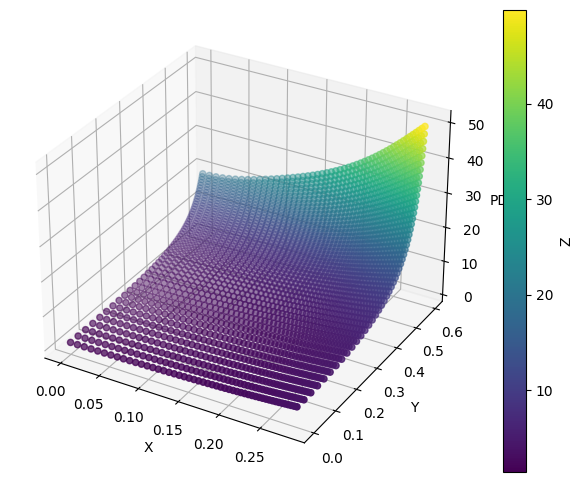

In [156]:
# Plot what the randomly initialized model looks like
plot_3D(model, True, [0,1])

Here we defined the function we wish to integrate.


In [157]:
@tf.function
def fox(x, y):
    return tf.math.cos(x**2/5)**2 * tf.math.cos(y**2/5)**2*tf.math.exp(-(x/5)**2- (y/5)**2)#(tf.math.cos((x**2)/4)**2)*tf.math.exp(-tf.math.square(x/5)) #(tf.math.cos(2*x)**2)*tf.math.exp(-(x/3)) #

Let's plot and see what the function looks like

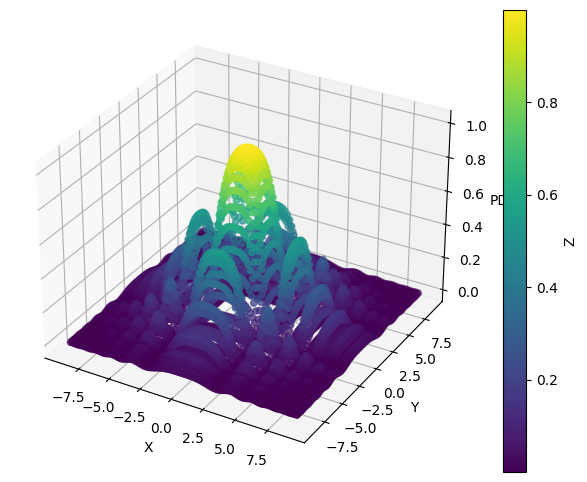

In [158]:
plot_3D(fox, False, [-9, 9], 100)

Create the dataset for training the model.

In [159]:
def create_dataset(nb):
    uni_data_x = gen_uni_random(500*nb,1)
    uni_data_y = gen_uni_random(500*nb,1)
    # uni_data_x, uni_data_y = np.meshgrid(uni_data_x, uni_data_y)
    # uni_data_x = tf.reshape(uni_data_x,[-1,1])
    # uni_data_y = tf.reshape(uni_data_y,[-1,1])

    data = tf.data.Dataset.from_tensor_slices((uni_data_x, uni_data_y)).shuffle(buffer_size=250000).batch(nb).shuffle(buffer_size=250000)
    return data
#data.take(1).get_single_element()

nb=750
data = create_dataset(nb)
print(data)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


## Custom Loss Function

In [160]:
@tf.function
def custom_loss(y_pred, epoch):
    # print(y_pred)
    x_set, y_set = y_pred
    x, pdf_inv_x = x_set
    y, pdf_inv_y = y_set

    n = tf.cast(tf.shape(x)[0], tf.float64)
    epoch = tf.cast(epoch, tf.float64)

    # computing f/pdf at different points
    # and its mean squared and squar of means.
    fdivP = tf.math.multiply(fox(x,y), pdf_inv_x * pdf_inv_y)
    fdivPsq = tf.math.square(fdivP)
    fdivPmean = tf.math.reduce_mean(fdivP)
    fdivPsqmean = tf.math.reduce_mean(fdivPsq)

    # The loss for minimizing the variance to increase Monte Carlo integration convergence.
    var_loss = (fdivPsqmean - tf.math.square(fdivPmean))

    # Loss to prevent the pdf from being negative
    neg_loss = tf.linalg.matmul(tf.linalg.matrix_transpose(tf.cast(tf.less(pdf_inv_x,0),tf.float64)), tf.math.abs(pdf_inv_x))
    neg_loss += tf.linalg.matmul(tf.linalg.matrix_transpose(tf.cast(tf.less(pdf_inv_y,0),tf.float64)), tf.math.abs(pdf_inv_y))

    x0_set, y0_set = model((tf.reshape(0.0,(1,)), tf.reshape(0.0,(1,))), training=True)
    x0, pdfx0 = x0_set
    y0, pdfy0 = y0_set
    x1_set, y1_set = model((tf.reshape(1.0,(1,)), tf.reshape(1.0,(1,))), training=True)
    x1, pdfx1 = x1_set
    y1, pdfy1 = y1_set

    range = 9

    # Loss to help spread the range of the random numbers produced
    pin_loss = (tf.square(-range - x0) + tf.square(range - x1)) + (tf.square(-range - y0) + tf.square(range - y1))

    total_loss =  var_loss + neg_loss + pin_loss
    return total_loss

In [161]:
test = data.take(1).get_single_element()
#test = tf.reshape(test, (-1,1))
#print(test)
custom_loss(model(test), 1)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[308.66778884]])>

In [162]:
@tf.function
def train_step(model, x_batch_train, epoch):
    with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss_value = custom_loss(pred, epoch)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    total_loss = tf.reduce_mean(loss_value)
    return total_loss


Epoch 1


Loss: 160.3868: 100%|██████████| 500/500 [00:11<00:00, 42.04it/s]



Epoch 2


Loss: 134.3087: 100%|██████████| 500/500 [00:09<00:00, 52.21it/s]



Epoch 3


Loss: 118.1732: 100%|██████████| 500/500 [00:09<00:00, 50.11it/s]



Epoch 4


Loss: 112.7762: 100%|██████████| 500/500 [00:09<00:00, 50.57it/s]



Epoch 5


Loss: 106.2287: 100%|██████████| 500/500 [00:09<00:00, 50.55it/s]



Epoch 6


Loss: 101.0100: 100%|██████████| 500/500 [00:09<00:00, 50.70it/s]



Epoch 7


Loss: 100.2886: 100%|██████████| 500/500 [00:09<00:00, 51.28it/s]



Epoch 8


Loss: 92.2319: 100%|██████████| 500/500 [00:09<00:00, 51.05it/s]



Epoch 9


Loss: 81.9169: 100%|██████████| 500/500 [00:09<00:00, 51.46it/s]



Epoch 10


Loss: 81.1513: 100%|██████████| 500/500 [00:09<00:00, 51.23it/s]



Epoch 11


Loss: 75.6252: 100%|██████████| 500/500 [00:09<00:00, 51.31it/s]



Epoch 12


Loss: 64.9593: 100%|██████████| 500/500 [00:09<00:00, 51.58it/s]



Epoch 13


Loss: 61.3887: 100%|██████████| 500/500 [00:09<00:00, 51.58it/s]



Epoch 14


Loss: 55.1333: 100%|██████████| 500/500 [00:09<00:00, 51.46it/s]



Epoch 15


Loss: 52.0900: 100%|██████████| 500/500 [00:09<00:00, 51.54it/s]



Epoch 16


Loss: 55.3246: 100%|██████████| 500/500 [00:09<00:00, 51.61it/s]



Epoch 17


Loss: 49.6890: 100%|██████████| 500/500 [00:09<00:00, 51.87it/s]



Epoch 18


Loss: 43.3886: 100%|██████████| 500/500 [00:09<00:00, 51.61it/s]



Epoch 19


Loss: 41.9548: 100%|██████████| 500/500 [00:09<00:00, 51.93it/s]



Epoch 20


Loss: 38.8047: 100%|██████████| 500/500 [00:09<00:00, 52.70it/s]



Epoch 21


Loss: 35.1990: 100%|██████████| 500/500 [00:09<00:00, 51.91it/s]



Epoch 22


Loss: 34.3483: 100%|██████████| 500/500 [00:09<00:00, 52.00it/s]



Epoch 23


Loss: 38.6600: 100%|██████████| 500/500 [00:09<00:00, 51.72it/s]



Epoch 24


Loss: 39.4221: 100%|██████████| 500/500 [00:09<00:00, 51.91it/s]



Epoch 25


Loss: 27.3673: 100%|██████████| 500/500 [00:09<00:00, 52.07it/s]



Epoch 26


Loss: 28.4836: 100%|██████████| 500/500 [00:09<00:00, 51.95it/s]



Epoch 27


Loss: 25.3048: 100%|██████████| 500/500 [00:09<00:00, 52.23it/s]



Epoch 28


Loss: 26.2553: 100%|██████████| 500/500 [00:09<00:00, 51.67it/s]



Epoch 29


Loss: 25.1737: 100%|██████████| 500/500 [00:09<00:00, 51.81it/s]



Epoch 30


Loss: 28.9710: 100%|██████████| 500/500 [00:09<00:00, 52.21it/s]



Epoch 31


Loss: 30.7522: 100%|██████████| 500/500 [00:09<00:00, 52.21it/s]



Epoch 32


Loss: 22.0391: 100%|██████████| 500/500 [00:09<00:00, 51.86it/s]



Epoch 33


Loss: 26.6663: 100%|██████████| 500/500 [00:09<00:00, 52.14it/s]



Epoch 34


Loss: 24.3263: 100%|██████████| 500/500 [00:09<00:00, 51.74it/s]



Epoch 35


Loss: 19.6254: 100%|██████████| 500/500 [00:09<00:00, 51.69it/s]



Epoch 36


Loss: 19.8385: 100%|██████████| 500/500 [00:09<00:00, 52.10it/s]



Epoch 37


Loss: 17.6556: 100%|██████████| 500/500 [00:09<00:00, 51.66it/s]



Epoch 38


Loss: 20.7023: 100%|██████████| 500/500 [00:09<00:00, 51.81it/s]



Epoch 39


Loss: 15.1563: 100%|██████████| 500/500 [00:09<00:00, 51.80it/s]



Epoch 40


Loss: 16.8736: 100%|██████████| 500/500 [00:09<00:00, 51.91it/s]



Epoch 41


Loss: 15.5303: 100%|██████████| 500/500 [00:09<00:00, 52.02it/s]



Epoch 42


Loss: 15.4846: 100%|██████████| 500/500 [00:09<00:00, 51.87it/s]



Epoch 43


Loss: 15.6091: 100%|██████████| 500/500 [00:09<00:00, 51.99it/s]



Epoch 44


Loss: 14.6363: 100%|██████████| 500/500 [00:09<00:00, 52.05it/s]



Epoch 45


Loss: 16.3180: 100%|██████████| 500/500 [00:09<00:00, 52.24it/s]



Epoch 46


Loss: 14.3785: 100%|██████████| 500/500 [00:09<00:00, 51.97it/s]



Epoch 47


Loss: 14.0906: 100%|██████████| 500/500 [00:09<00:00, 51.66it/s]



Epoch 48


Loss: 13.3506: 100%|██████████| 500/500 [00:09<00:00, 51.96it/s]



Epoch 49


Loss: 13.5850: 100%|██████████| 500/500 [00:09<00:00, 51.95it/s]



Epoch 50


Loss: 13.6713: 100%|██████████| 500/500 [00:09<00:00, 51.77it/s]



Epoch 51


Loss: 13.7825: 100%|██████████| 500/500 [00:09<00:00, 51.67it/s]



Epoch 52


Loss: 13.5264: 100%|██████████| 500/500 [00:09<00:00, 51.71it/s]



Epoch 53


Loss: 13.7556: 100%|██████████| 500/500 [00:09<00:00, 52.27it/s]



Epoch 54


Loss: 14.8767: 100%|██████████| 500/500 [00:09<00:00, 51.87it/s]



Epoch 55


Loss: 13.0747: 100%|██████████| 500/500 [00:09<00:00, 52.17it/s]



Epoch 56


Loss: 13.2463: 100%|██████████| 500/500 [00:09<00:00, 51.52it/s]



Epoch 57


Loss: 12.8496: 100%|██████████| 500/500 [00:09<00:00, 52.01it/s]



Epoch 58


Loss: 14.8337: 100%|██████████| 500/500 [00:09<00:00, 52.21it/s]



Epoch 59


Loss: 13.5706: 100%|██████████| 500/500 [00:09<00:00, 52.00it/s]



Epoch 60


Loss: 12.7287: 100%|██████████| 500/500 [00:09<00:00, 51.85it/s]



Epoch 61


Loss: 12.2965: 100%|██████████| 500/500 [00:09<00:00, 51.80it/s]



Epoch 62


Loss: 12.6610: 100%|██████████| 500/500 [00:09<00:00, 51.88it/s]



Epoch 63


Loss: 11.7155: 100%|██████████| 500/500 [00:09<00:00, 51.64it/s]



Epoch 64


Loss: 11.7494: 100%|██████████| 500/500 [00:09<00:00, 52.12it/s]



Epoch 65


Loss: 11.4877: 100%|██████████| 500/500 [00:09<00:00, 51.66it/s]



Epoch 66


Loss: 11.2733: 100%|██████████| 500/500 [00:09<00:00, 51.53it/s]



Epoch 67


Loss: 11.1570: 100%|██████████| 500/500 [00:09<00:00, 52.20it/s]



Epoch 68


Loss: 11.1619: 100%|██████████| 500/500 [00:09<00:00, 52.39it/s]



Epoch 69


Loss: 11.1784: 100%|██████████| 500/500 [00:09<00:00, 51.20it/s]



Epoch 70


Loss: 11.2435: 100%|██████████| 500/500 [00:09<00:00, 52.00it/s]



Epoch 71


Loss: 11.0704: 100%|██████████| 500/500 [00:09<00:00, 51.88it/s]



Epoch 72


Loss: 10.6820: 100%|██████████| 500/500 [00:09<00:00, 51.73it/s]



Epoch 73


Loss: 10.8611: 100%|██████████| 500/500 [00:09<00:00, 52.11it/s]



Epoch 74


Loss: 10.8251: 100%|██████████| 500/500 [00:09<00:00, 52.25it/s]



Epoch 75


Loss: 10.7627: 100%|██████████| 500/500 [00:09<00:00, 52.23it/s]


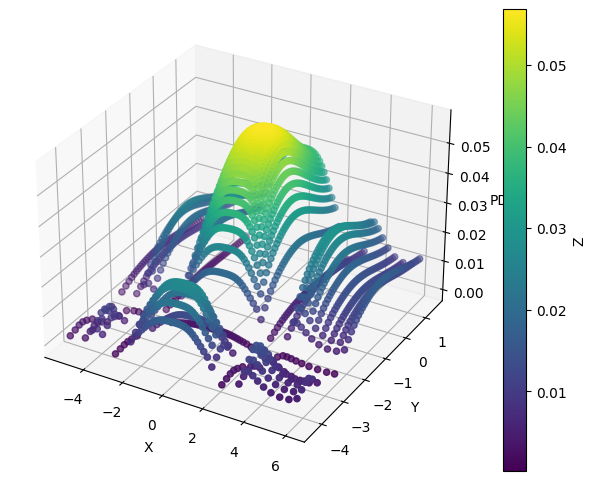

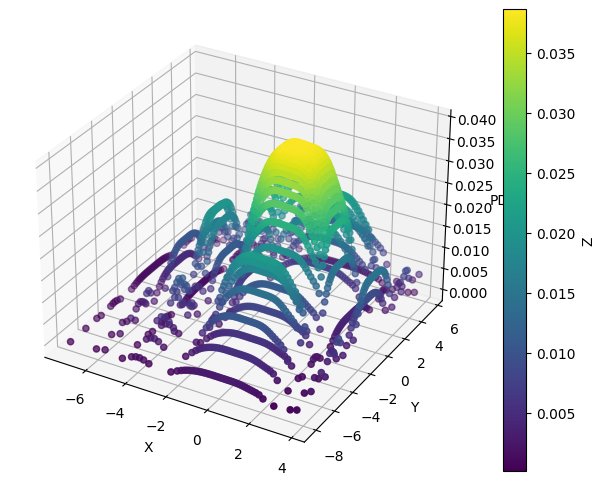

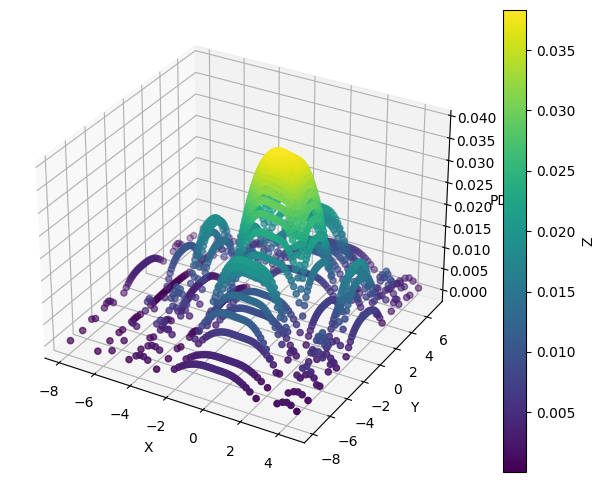

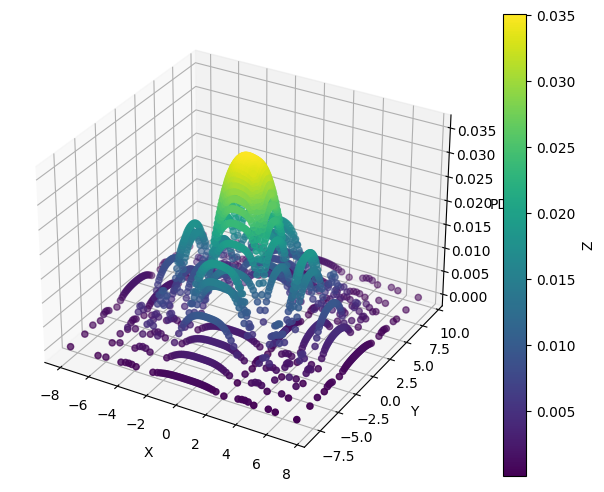

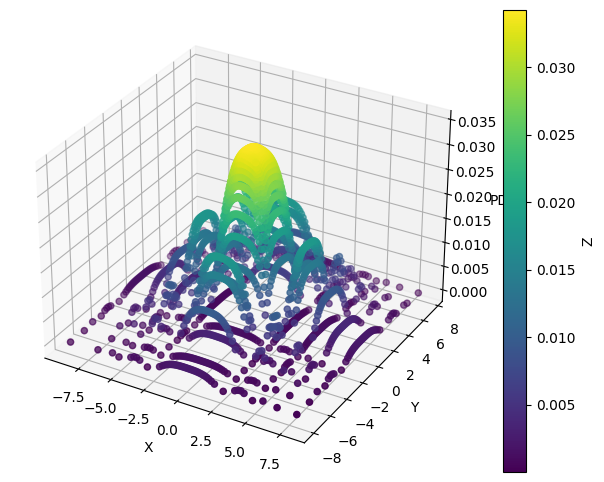

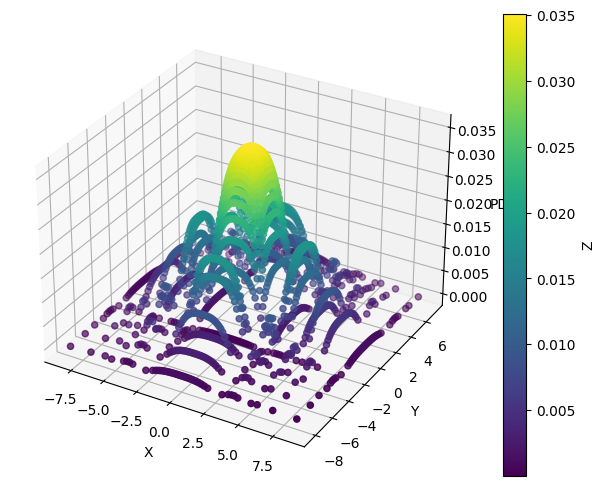

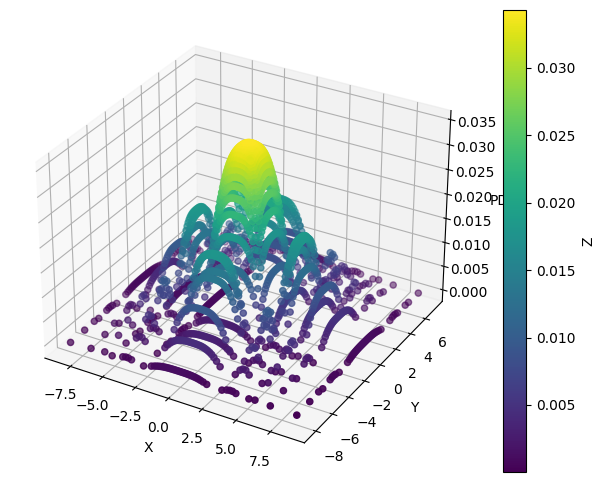

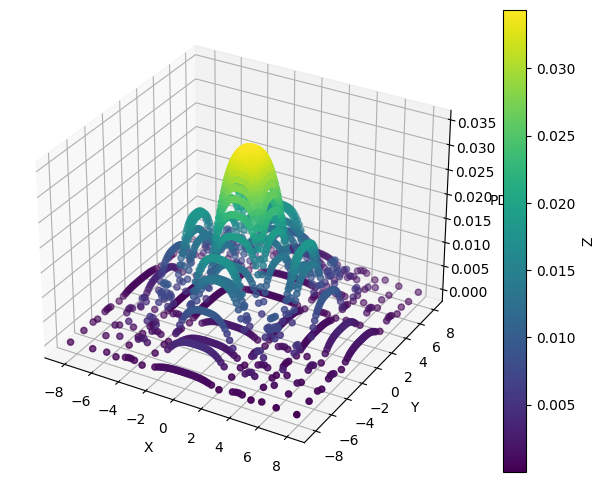

In [163]:
epochs = 75
steps_per_epoch = data.cardinality().numpy()
for epoch in range(epochs):

    print("\nEpoch %d" % (epoch+1,))
    #data = create_dataset(nb)
    total_loss = 0
    pdf_avg = 0
    with tqdm(total=steps_per_epoch) as pbar:
        for step, x_batch_train in enumerate(data):
            total_loss += train_step(model, x_batch_train, epoch)
            pbar.update(1)
            pbar.set_description(f'Loss: {total_loss / (step + 1):.4f}')

    # Plot the PDF every k-th epoch
    if tf.math.floormod(epoch,10) == 0:
        plot_3D(model, True, [0,1])

Let's plot what our final PDF looks like with more points

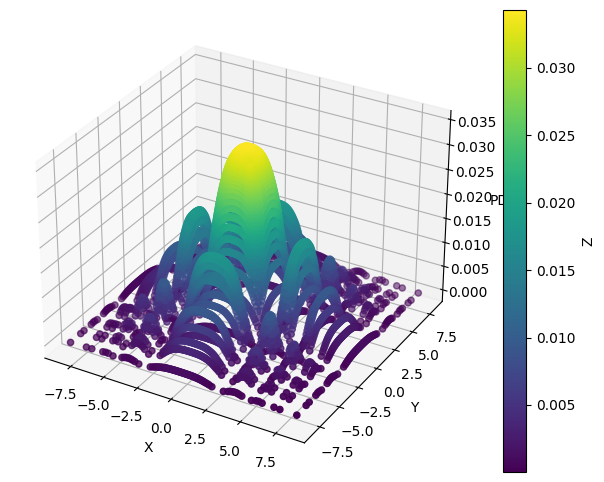

In [164]:
plot_3D(model, True, [0,1], 100)